In [4]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm import tqdm  # Changed from tqdm.notebook for better Kaggle compatibility

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout, 
                                   concatenate, Bidirectional, Dot, Activation, 
                                   RepeatVector, Multiply, Lambda)

# NLTK for BLEU score
try:
    from nltk.translate.bleu_score import corpus_bleu
except ImportError:
    import nltk
    nltk.download('punkt')
    from nltk.translate.bleu_score import corpus_bleu

# Directory settings
INPUT_DIR = '/kaggle/input/flickr8k'
OUTPUT_DIR = '/kaggle/working'
IMAGE_DIR = os.path.join(INPUT_DIR, 'Images')
CAPTION_FILE = os.path.join(INPUT_DIR, 'captions.txt')

# Verify paths exist
assert os.path.exists(INPUT_DIR), f"Input directory not found: {INPUT_DIR}"
assert os.path.exists(IMAGE_DIR), f"Image directory not found: {IMAGE_DIR}"
assert os.path.exists(CAPTION_FILE), f"Caption file not found: {CAPTION_FILE}"

def load_vgg_model():
    """Load and modify VGG16 model for feature extraction"""
    base_model = VGG16()
    model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
    print("VGG16 model loaded successfully")
    return model

def extract_features(model, image_dir):
    """Extract features from images using VGG16"""
    features = {}
    for img_name in tqdm(os.listdir(image_dir), desc="Extracting features"):
        # Skip non-image files if any
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        try:
            # Load and preprocess image
            img_path = os.path.join(image_dir, img_name)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            
            # Extract features
            feature = model.predict(image, verbose=0)
            
            # Store features
            image_id = img_name.split('.')[0]
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing image {img_name}: {str(e)}")
            continue
    
    return features

def load_captions(caption_file):
    """Load and process image captions"""
    mapping = defaultdict(list)
    
    with open(caption_file, 'r', encoding='utf-8') as file:
        next(file)  # Skip header
        for line in file:
            try:
                tokens = line.strip().split(',')
                if len(tokens) < 2:
                    continue
                    
                image_id = tokens[0].split('.')[0]
                caption = ','.join(tokens[1:]).strip()  # Rejoin caption in case it contains commas
                mapping[image_id].append(caption)
            except Exception as e:
                print(f"Error processing caption line: {str(e)}")
                continue
    
    return mapping

def clean_captions(mapping):
    """Clean and preprocess captions"""
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Preprocessing steps
            caption = caption.lower()
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            caption = ' '.join(caption.split())  # More robust than replace
            caption = 'startseq ' + ' '.join(word for word in caption.split() 
                                           if len(word) > 1) + ' endseq'
            captions[i] = caption

def main():
    """Main execution function"""
    # Load VGG model
    print("Loading VGG model...")
    vgg_model = load_vgg_model()
    
    # Extract and save image features
    print("\nExtracting image features...")
    image_features = extract_features(vgg_model, IMAGE_DIR)
    feature_file = os.path.join(OUTPUT_DIR, 'img_features.pkl')
    with open(feature_file, 'wb') as f:
        pickle.dump(image_features, f)
    print(f"Features saved to {feature_file}")
    
    # Load and process captions
    print("\nProcessing captions...")
    mapping = load_captions(CAPTION_FILE)
    clean_captions(mapping)
    
    # Create tokenizer
    all_captions = [caption for captions in mapping.values() for caption in captions]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    
    # Save tokenizer
    tokenizer_file = os.path.join(OUTPUT_DIR, 'tokenizer.pkl')
    with open(tokenizer_file, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"Tokenizer saved to {tokenizer_file}")
    
    # Calculate and print vocabulary statistics
    max_length = max(len(tokenizer.texts_to_sequences([caption])[0]) 
                    for caption in all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    
    print(f"\nVocabulary Size: {vocab_size}")
    print(f"Maximum Caption Length: {max_length}")
    print(f"Total number of captions: {len(all_captions)}")

if __name__ == "__main__":
    main()

Loading VGG model...
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
VGG16 model loaded successfully

Extracting image features...


Extracting features: 100%|██████████| 8091/8091 [09:57<00:00, 13.53it/s]


Features saved to /kaggle/working/img_features.pkl

Processing captions...
Tokenizer saved to /kaggle/working/tokenizer.pkl

Vocabulary Size: 8768
Maximum Caption Length: 34
Total number of captions: 40455


In [8]:
# First, load the saved features and tokenizer
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout, 
                                   concatenate, Bidirectional, Dot, Activation, 
                                   RepeatVector, Multiply, Lambda)
from math import ceil

# Load the saved features and tokenizer
OUTPUT_DIR = '/kaggle/working'
with open(OUTPUT_DIR + '/img_features.pkl', 'rb') as f:
    loaded_features = pickle.load(f)
    
with open(OUTPUT_DIR + '/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Calculate vocabulary size and max length (needed for the model)
all_captions = []
image_to_captions_mapping = {}

# Read captions file again to recreate mapping
CAPTION_FILE = '/kaggle/input/flickr8k/captions.txt'
with open(CAPTION_FILE, 'r', encoding='utf-8') as file:
    next(file)  # Skip header
    for line in file:
        tokens = line.strip().split(',')
        image_id = tokens[0].split('.')[0]
        caption = ','.join(tokens[1:]).strip()
        
        # Clean caption
        caption = caption.lower()
        caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
        caption = ' '.join(caption.split())
        caption = 'startseq ' + ' '.join(word for word in caption.split() 
                                       if len(word) > 1) + ' endseq'
        
        if image_id not in image_to_captions_mapping:
            image_to_captions_mapping[image_id] = []
        image_to_captions_mapping[image_id].append(caption)
        all_captions.append(caption)

# Calculate max_caption_length and vocab_size
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) 
                        for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

print(f"Loaded features for {len(loaded_features)} images")
print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Caption Length: {max_caption_length}")

Loaded features for 8091 images
Vocabulary Size: 8768
Maximum Caption Length: 34


In [9]:
# Creating train-test split
image_ids = list(image_to_captions_mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

print(f"Training samples: {len(train)}")
print(f"Testing samples: {len(test)}")

# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0
    
    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]
            
            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1_batch.append(features[image_id][0])
                    X2_batch.append(in_seq)
                    y_batch.append(out_seq)
                    
                    batch_count += 1
                    
                    if batch_count == batch_size:
                        yield [np.array(X1_batch), np.array(X2_batch)], np.array(y_batch)
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

Training samples: 7281
Testing samples: 810


In [10]:
# First, modify the data generator to ensure proper data types and masking
def create_data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    def generator():
        while True:
            # Shuffle the data keys
            np.random.shuffle(data_keys)
            
            # Process each image
            for image_id in data_keys:
                captions = image_to_captions_mapping[image_id]
                
                # Select a random caption for this image
                caption = np.random.choice(captions)
                caption_seq = tokenizer.texts_to_sequences([caption])[0]
                
                # Create sequences
                for i in range(1, len(caption_seq)):
                    in_seq = caption_seq[:i]
                    out_seq = caption_seq[i]
                    
                    # Pad sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical(out_seq, num_classes=vocab_size)
                    
                    # Convert feature vector to float32
                    img_feature = features[image_id][0].astype(np.float32)
                    
                    # Yield the data
                    yield (img_feature, in_seq.astype(np.float32)), out_seq.astype(np.float32)
    
    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (
                tf.TensorSpec(shape=(4096,), dtype=tf.float32),
                tf.TensorSpec(shape=(max_caption_length,), dtype=tf.float32)
            ),
            tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
        )
    )
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Modified model creation function with proper masking and cuDNN settings
def create_caption_model(vocab_size, max_caption_length):
    # Image feature input
    inputs1 = Input(shape=(4096,), name='image_features')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Project and process image features
    fe2_projected = RepeatVector(max_caption_length)(fe2)
    
    # Disable cuDNN for LSTM layers to allow proper masking
    lstm_kwargs = {
        'units': 256,
        'return_sequences': True,
        'use_bias': True,
        'dropout': 0.5,
        'recurrent_dropout': 0.5
    }
    
    fe2_projected = Bidirectional(
        LSTM(**lstm_kwargs)
    )(fe2_projected)
    
    # Sequence input
    inputs2 = Input(shape=(max_caption_length,), name='caption_input')
    se1 = Embedding(vocab_size, 256)(inputs2)
    se2 = Dropout(0.5)(se1)
    
    se3 = Bidirectional(
        LSTM(**lstm_kwargs)
    )(se2)
    
    # Attention mechanism
    attention = Dot(axes=[2, 2])([fe2_projected, se3])
    attention_scores = Activation('softmax')(attention)
    context_vector = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)
    
    # Decoder
    decoder_input = concatenate([context_vector, fe2])
    decoder1 = Dense(256, activation='relu')(decoder_input)
    outputs = Dense(vocab_size, activation='softmax')(decoder1)
    
    # Create model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    # Use a lower learning rate for stability
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    
    return model

# Modified training function
def train_caption_model(train, test, image_to_captions_mapping, loaded_features, 
                       tokenizer, max_caption_length, vocab_size, 
                       batch_size=32, epochs=50):
    # Create model
    model = create_caption_model(vocab_size, max_caption_length)
    print("Model created successfully!")
    model.summary()
    
    # Create datasets
    train_dataset = create_data_generator(
        train, image_to_captions_mapping, loaded_features,
        tokenizer, max_caption_length, vocab_size, batch_size
    )
    
    test_dataset = create_data_generator(
        test, image_to_captions_mapping, loaded_features,
        tokenizer, max_caption_length, vocab_size, batch_size
    )
    
    # Calculate steps
    steps = ceil(len(train) * 5 / batch_size)  # Approximate steps per epoch
    val_steps = ceil(len(test) * 5 / batch_size)
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=steps,
        validation_data=test_dataset,
        validation_steps=val_steps,
        verbose=1
    )
    
    return model, history

# Execute training
model, history = train_caption_model(
    train=train,
    test=test,
    image_to_captions_mapping=image_to_captions_mapping,
    loaded_features=loaded_features,
    tokenizer=tokenizer,
    max_caption_length=max_caption_length,
    vocab_size=vocab_size
)

# Save the model
model.save(OUTPUT_DIR + '/caption_model.h5')
print("Model saved successfully!")

Model created successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_features            │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ image_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_input             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,244,608 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 34, 256)        │              0 │ dense[0][0]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 34, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 34, 512)        │      1,050,624 │ repeat_vector[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 34, 512)        │      1,050,624 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 34, 34)         │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 34, 34)         │              0 │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 34, 512)        │              0 │ activation[0][0],      │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 512)            │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 768)            │              0 │ lambda_1[0][0],        │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        196,864 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)      

 Total params: 7,844,928 (29.93 MB)

 Trainable params: 7,844,928 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 168s 139ms/step - loss: 6.3670 - val_loss: 5.5024
Epoch 2/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 159s 140ms/step - loss: 5.5256 - val_loss: 5.2690
Epoch 3/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 158s 138ms/step - loss: 5.2891 - val_loss: 5.1666
Epoch 4/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 157s 138ms/step - loss: 5.1993 - val_loss: 5.1199
Epoch 5/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 159s 140ms/step - loss: 5.0805 - val_loss: 5.0762
Epoch 6/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 157s 138ms/step - loss: 4.9798 - val_loss: 4.9752
Epoch 7/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 158s 139ms/step - loss: 4.9499 - val_loss: 4.9476
Epoch 8/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 159s 140ms/step - loss: 4.8922 - val_loss: 5.0057
Epoch 9/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 159s 140ms/step - loss: 4.8380 - val_loss: 4.9671
Epoch 10/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 159s 140ms/step - loss: 4.8168 - val_loss: 4.9317
Epoch 11/50
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 157s 138ms/step - loss: 4.7714 - val

In [11]:
# --- Caption Generation and Evaluation Functions ---

def get_word_from_index(index, tokenizer):
    """Return the word corresponding to an index in the tokenizer."""
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

def predict_caption(model, image_features, tokenizer, max_caption_length):
    """
    Generate a caption for given image features using greedy search.
    
    Parameters:
      model             : Trained caption model.
      image_features    : Feature vector for the image (should have shape (1,4096) or (4096,)).
      tokenizer         : Tokenizer fitted on the captions.
      max_caption_length: Maximum length of caption sequences.
    
    Returns:
      caption           : The generated caption (string).
    """
    # Initialize the caption with the start token.
    caption = 'startseq'
    
    # Generate words until max_caption_length is reached.
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices.
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match max_caption_length.
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution.
        yhat = model.predict([image_features, sequence], verbose=0)
        # Select the index with the highest probability.
        predicted_index = np.argmax(yhat)
        # Convert the index back to a word.
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        # Append the predicted word to the caption.
        caption += " " + predicted_word
        # Stop if no word is found or if the end token is generated.
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

# --- Evaluate BLEU Scores on the Test Set ---
from tqdm import tqdm  # Ensure tqdm is available (imported in Cell 1)

actual_captions_list = []
predicted_captions_list = []

for key in tqdm(test, desc="Evaluating BLEU scores"):
    # Get the list of actual captions for the image.
    actual_captions = image_to_captions_mapping[key]
    # Predict a caption using the model.
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Convert captions to lists of words for BLEU evaluation.
    actual_captions_words = [caption.split() for caption in actual_captions]
    predicted_caption_words = predicted_caption.split()
    
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU-1 and BLEU-2 scores using NLTK's corpus_bleu
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

# --- Function to Generate and Display Caption for a Single Image ---

def generate_caption(image_name):
    """
    Load an image by its filename, print its actual captions, predict a caption,
    and display the image.
    
    Parameters:
      image_name : Filename of the image (e.g., "101669240_b2d3e7f17b.jpg").
    """
    # Extract image ID (filename without extension)
    image_id = image_name.split('.')[0]
    # Construct image path
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    
    # Load the image using PIL.
    image = Image.open(img_path)
    
    # Print actual captions.
    print('---------------------Actual---------------------')
    for caption in image_to_captions_mapping[image_id]:
        print(caption)
    
    # Predict the caption using the trained model.
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    
    # Display the image using matplotlib.
    plt.imshow(image)
    plt.axis('off')
    plt.show()


Evaluating BLEU scores: 100%|██████████| 810/810 [13:25<00:00,  1.01it/s]


BLEU-1: 0.458528
BLEU-2: 0.277581


---------------------Actual---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
--------------------Predicted--------------------
startseq dog is running through snow endseq


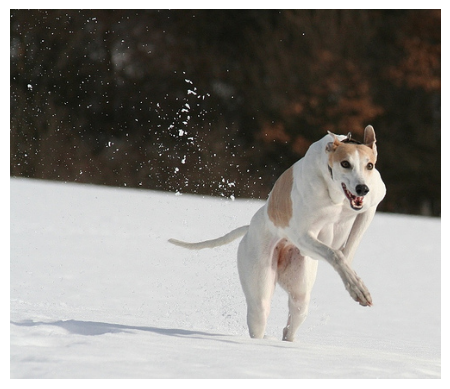

In [14]:
# Cell B: Generate and display caption for a specific image
generate_caption("101654506_8eb26cfb60.jpg")
